[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdehling/neural-style-transfer/blob/main/dumoulin2017.ipynb)

# Introduction

In [ ]:
try:
    from google import colab
    RUNNING_ON_COLAB = True

    !git init .
    !git remote add origin https://github.com/mdehling/neural-style-transfer.git
    !git pull --depth=1 origin main
    !git submodule update --init

except:
    RUNNING_ON_COLAB = False

In [1]:
from os import environ as env
env['TF_CPP_MIN_LOG_LEVEL'] = '2'               # hide info & warnings
env['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'       # grow GPU memory as needed

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

import nstesia as nst

tfds.disable_progress_bar()                     # progress bar mangles output

In [2]:
TRAINING_MODE = False

In [10]:
style_images = [
    nst.utils.image.load_images(file, min_dim=256)
    for file in [
        'img/candy.jpeg',           # 0
        'img/cubism.jpeg',          # 1
        'img/udnie.jpeg',           # 2
        'img/la-muse.jpeg',         # 3
        'img/scream.jpeg',          # 4
        'img/starry-night.jpeg',    # 5
        'img/bathing.jpeg',         # 6
        'img/delauney.jpeg',        # 7
        'img/pisarro.jpeg',         # 8
        'img/blue-boat.jpeg',       # 9
        'img/white-ships.jpeg',     # 10
        'img/autumn.jpeg',          # 11
        'img/simplon-lesson.jpeg',  # 12
        'img/apples.jpeg',          # 13
        'img/delfts-blauw.jpeg',    # 14
        'img/tavern.jpeg',          # 15
        'img/le-bouchon.jpeg',      # 16
        'img/rooftops.jpeg',        # 17
        'img/piazetta.jpeg',        # 18
        'img/nude.jpeg',            # 19
        'img/triangles.jpeg',       # 20
        'img/squares.jpeg',         # 21
        'img/mondrian.jpeg',        # 22
        'img/cubes.jpeg',           # 23
        'img/stained-glass.jpeg',   # 24
        'img/fractal.jpeg',         # 25
        'img/mosaic.jpeg',          # 26
        'img/galaxy.jpeg',          # 27
        'img/smoke.jpeg',           # 28
        'img/watercolor.jpeg',      # 29
        'img/wireframe.jpeg',       # 30
        'img/circuit.jpeg',         # 31
    ]
]
n_styles = len(style_images)

In [4]:
if TRAINING_MODE is True:
    coco_ds = tfds.load('coco/2014', split='train', data_dir='/tmp')
    coco_ds = coco_ds.map( lambda data: tf.cast(data['image'], dtype=tf.float32) )
    coco_ds = coco_ds.map( lambda image: tf.image.resize(image, [256,256]) )

    enum_ds = tf.data.Dataset.from_tensor_slices(
        [i for i in range(len(style_images))]
    ).repeat()

    train_ds = tf.data.Dataset.zip((coco_ds,enum_ds))
    train_ds = train_ds.batch(4).prefetch(tf.data.AUTOTUNE)

In [5]:
if TRAINING_MODE is True:
    transfer_model = nst.models.DumoulinStyleTransfer(style_images)

    optimizer = tf.keras.optimizers.Adam(1e-3)

    total_loss_fn = nst.losses.Total(
        losses=[
            nst.losses.DumoulinStyle(style_images),
            nst.losses.DumoulinContent(),
        ],
        weights=(7.0,1.0)
    )

    transfer_model.compile(optimizer, total_loss_fn)

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            f'weights/dumoulin2017-exp2-{{epoch}}.h5', save_freq='epoch'
        )
    ]

    transfer_model.fit(train_ds, callbacks=callbacks, epochs=5)

else:
    transfer_model = nst.models.DumoulinStyleTransfer.from_checkpoint(
        'weights/dumoulin2017-exp2-1.h5'
    )

In [6]:
def show_style_matrix(image, styles):
    stylized_images = []
    for i in range(5):
        for j in range(5):
            style_vector = tf.reshape(
                (4-i)*(4-j) * tf.one_hot(styles[0],n_styles) +
                (4-i)*j * tf.one_hot(styles[1],n_styles) +
                i*(4-j) * tf.one_hot(styles[2],n_styles) +
                i*j * tf.one_hot(styles[3],n_styles),
                (1,-1)
            ) / 16
            stylized_images.append(
                transfer_model( (image, style_vector) )
            )

    nst.utils.image.show_images(stylized_images, n_cols=5)

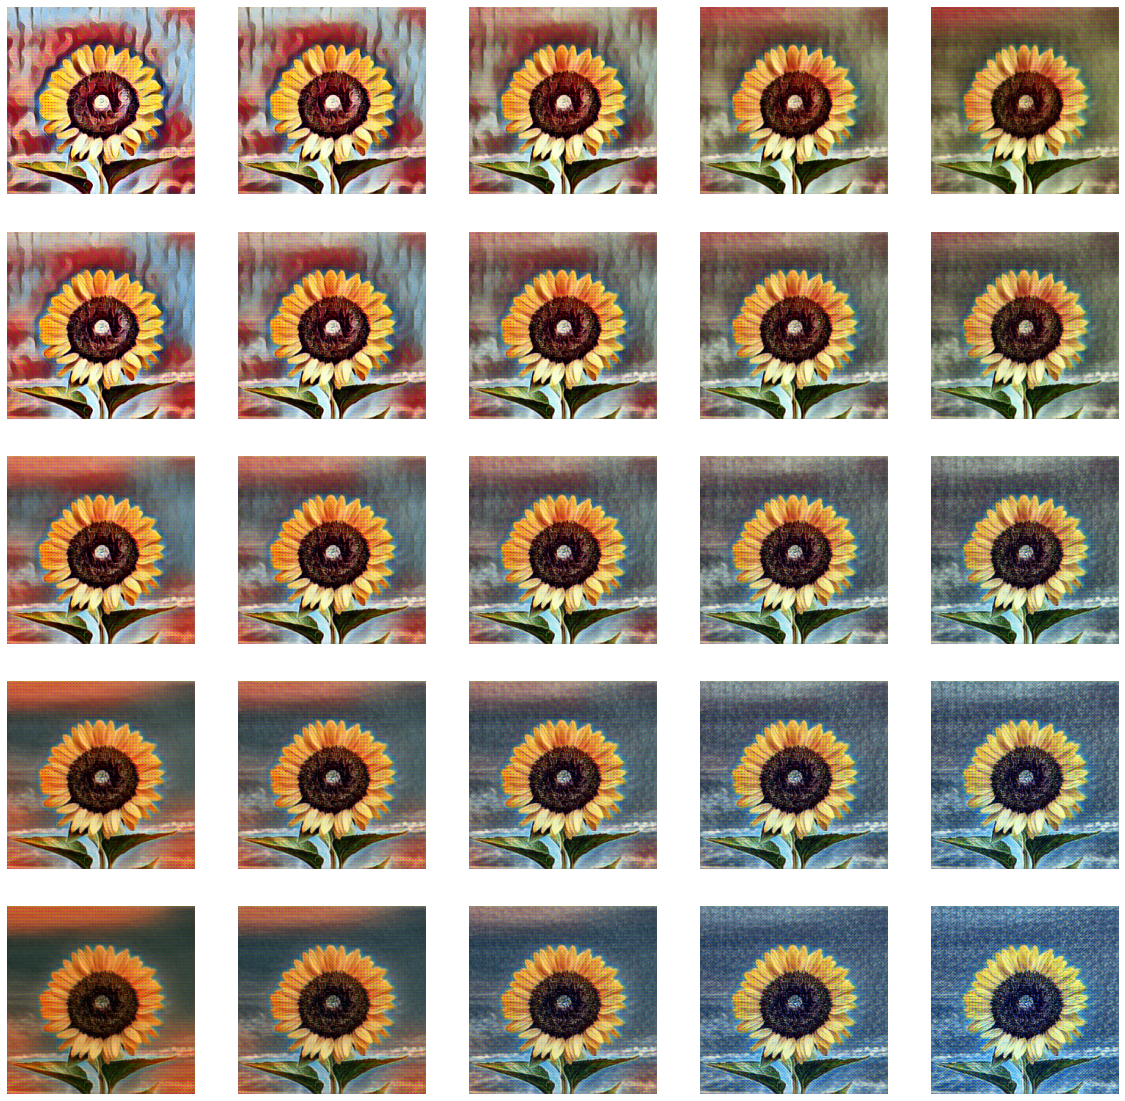

In [7]:
content_image = nst.utils.image.load_images('img/bergbau-museum.jpeg', min_dim=256)
show_style_matrix(content_image, [0,1,2,3])

In [ ]:
content_image = nst.utils.image.load_images('img/sunflower.jpeg', min_dim=256)
show_style_matrix(content_image, [5,6,7,8])

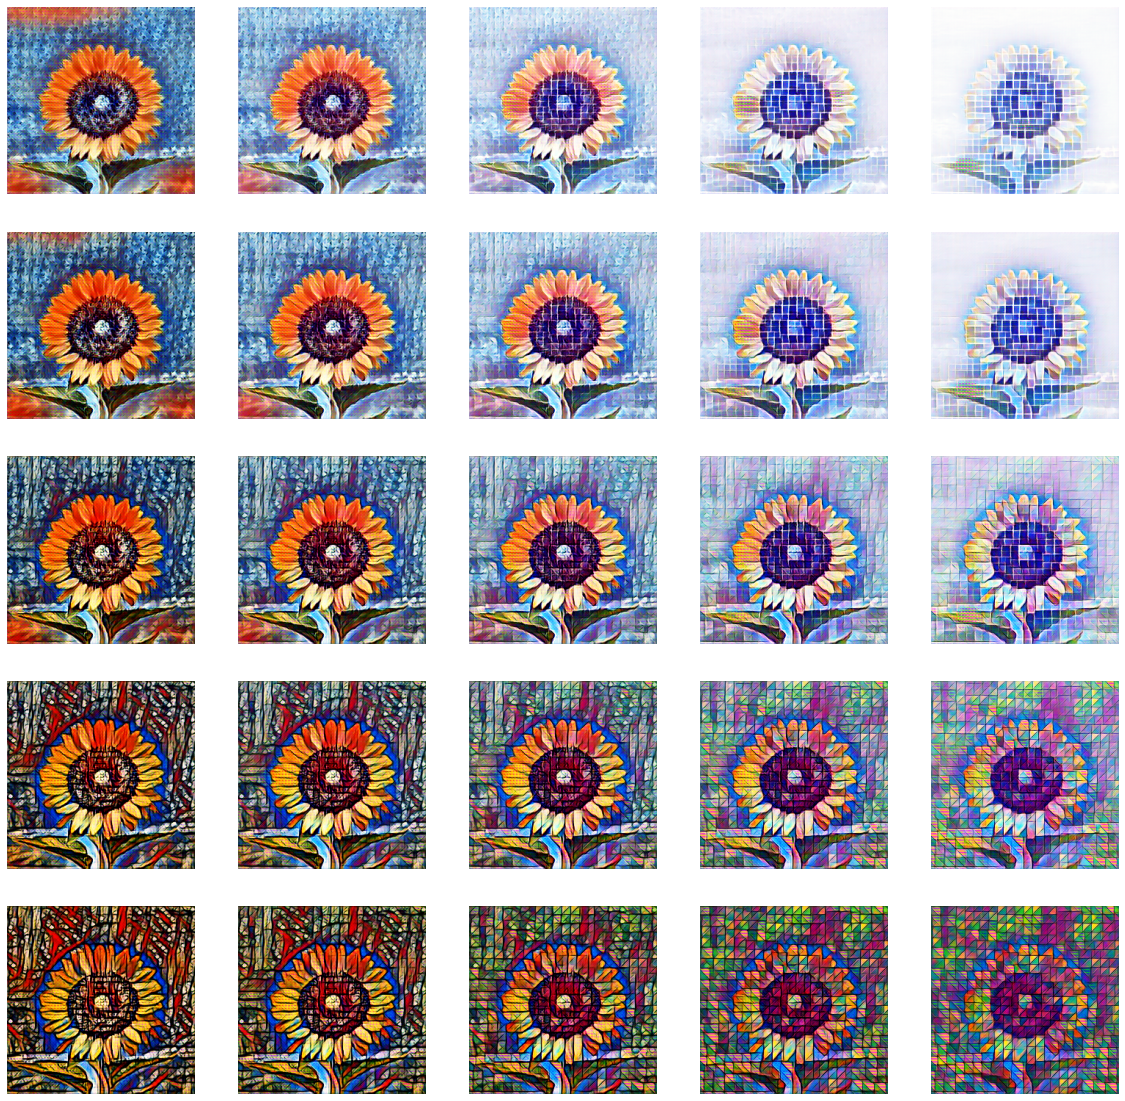

In [9]:
content_image = nst.utils.image.load_images('img/sunflower.jpeg', min_dim=256)
show_style_matrix(content_image, [9,10,11,12])

# References
1. Dumoulin, Shlens, Kudlur - _A Learned Representation for Artistic Style_, 2017.
2. Gatys, Ecker, Bethge - _Texture Synthesis Using Convolutional Neural Networks_, 2015.
3. Gatys, Ecker, Bethge - _A Neural Algorithm of Artistic Style_, 2015.
4. Johnson, Alahi, Fei-Fei - _Perceptual Losses for Real-Time Style Transfer and Super-Resolution_, 2016.
5. Ulyanov, Vedaldi, Lempitsky - _Instance Normalization: The Missing Ingredient for Fast Stylization_, 2016.
6. Lin et al - _Microsoft COCO: Common Objects in Context_, 2014.
